# 자동 미분과 그래디언트 테이프

## 그레디언트 테이프

- 텐서플로는 자동미분을 위한 `tf.GradientTape` API를 제공
- `tf.GradientTape`는 컨텍스트 안에서 실행된 모든 연산을 테이프에 '기록'
- 후진 방식 자동 미분(reverse mode differetiation)을 사용해서 테이프에 '기록된' 연산 그래디언트를 계산

In [1]:
import tensorflow as tf

print(tf.__version__)

2.4.0


In [ ]:
x = tf.ones((2, 2))
# 1, 1
# 1, 1
with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  print('y: ', y)
  z = tf.multiply(y, y)
  print('z: ', z)

# 입력 텐서 x에 대한 z의 도함수
dz_dx = t.gradient(z, x)
print(dz_dx)
for i in [0, 1]:
  for j in [0, 1]:
    # AssertionError가 발생하지 않음
    assert dz_dx[i][j].numpy() == 8.0

y:  tf.Tensor(4.0, shape=(), dtype=float32)
z:  tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


In [ ]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

# tf.GradientTape() 안에서 계산된 중간 값에 대한 그래디언트도 구할 수 있습니다.
# 테이프 사용하여 중간값 y에 대한 도함수를 계산합니다. 
dz_dy = t.gradient(z, y)
assert dz_dy.numpy() == 8.0

- `GradientTape.gradient()` 메소드가 호출되면 GradientTape에 포함된 리소스가 해제됨
- 동일한 연산에 대해 여러 그래디언트를 계산하려면 지속성있는(`persistent=True`) 그래디언트 테이프를 생성하면 됨
- 이렇게 생성한 그래디언트 테이프틑 `gradient()` 메소드의 다중 호출을 허용



In [ ]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as t:
  t.watch(x)
  y = x * x
  z = y * y.  # z = x ^ 4
dz_dx = t.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
print(dz_dx)
dy_dx = t.gradient(y, x)  # 6.0   (2 * x at x = 3)
print(dy_dx)
del t  # 테이프에 대한 참조를 삭제합니다.

tf.Tensor(108.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


## 제어 흐름 기록
- 연산이 실행되는 순서대로 테이프에 기록되기 때문에, 파이썬 제어흐름이 자연스럽게 처리됨

In [ ]:
def f(x, y):
  output = 1.0
  for i in range(y):
    if i > 1 and i < 5:   # output(1) * 2 * 3 * 4
      output = tf.multiply(output, x)
  return output

def grad(x, y):
  with tf.GradientTape() as t:
    t.watch(x)
    out = f(x, y)
  return t.gradient(out, x)

x = tf.convert_to_tensor(2.0)

print(grad(x, 6).numpy())
assert grad(x, 6).numpy() == 12.0

print(grad(x, 5).numpy())
assert grad(x, 5).numpy() == 12.0

print(grad(x, 4).numpy())
assert grad(x, 4).numpy() == 4.0

12.0
12.0
4.0


## 고계도(Higher-order) 그래디언트
- `GradientTape` 컨텍스트 매니저 안에 있는 연산들은 자동미분을 위해 기록됨
- 만약 이 컨텍스트 안에서 그래디언트를 계산하면 해당 그래디언트 연산 또한 기록됨

In [ ]:
x = tf.Variable(1.0) 

with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x
  # 't' 컨텍스트 매니저 안의 그래디언트를 계산합니다.
  # 이것은 또한 그래디언트 연산 자체도 미분가능하다는 것을 의미합니다. 
  dy_dx = t2.gradient(y, x)      # dy_dx = 3 * x^2 at x = 1
d2y_dx2 = t.gradient(dy_dx, x)   # d2y_dx2 = 6 * x at x = 1

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0

# ANN(Artificial Neural Network)

## Sequential 모델을 사용하는 경우
- `Sequential` 모델은 각 레이어에 정확히 하나의 입력 텐서와 하나의 출력 텐서가 있는 일반 레이어 스택에 적합

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),  # Pytorch - nn.Linear 
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
# [1, 1, 1] --> [o, o] --> [o, o, o] --> [o, o, o, o]
y = model(x)
print(y)

tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(3, 4), dtype=float32)


In [ ]:
# Create 3 layers
# 위의 함수와 동일
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Conv1d(4, name="layer3")

# Call layers on a test input
x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))
print(y) # y = w * x

tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(3, 4), dtype=float32)


In [ ]:
# layers 속성을 사용해서 레이어에 대해 접근할 수 있음
model.layers

In [ ]:
# add() 메서드를 통해서 Sequential 모델을 점진적으로 작성할 수도 있음
model = keras.Sequential()
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

In [ ]:
model.layers

In [ ]:
# pop() 메서드를 사용하면 레이어를 제거할 수 있음
model.pop()
print(len(model.layers))  # 2

2


## 패션 MNIST를 사용한 분류 문제
- 패션 MNIST 데이터에는 10개의 카테고리와 70,000개의 흑백이미지가 포함
- 이미지의 해상도는 28*28
- 네트워크 훈련에 60,000개의 이미지를 사용하고, 평가를 위해 10,000개를 사용

In [ ]:
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.0


In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
len(train_labels)

60000

In [ ]:
# 각 라벨은 0~9 사이의 정수
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### 데이터 전처리

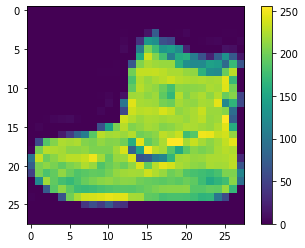

In [ ]:
# 훈련 데이터의 첫번째 이미지
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
# 신경망 모델에 주입하기 전에 값의 범위를 0~1로 조정
train_images = train_images / 255.0

test_images = test_images / 255.0

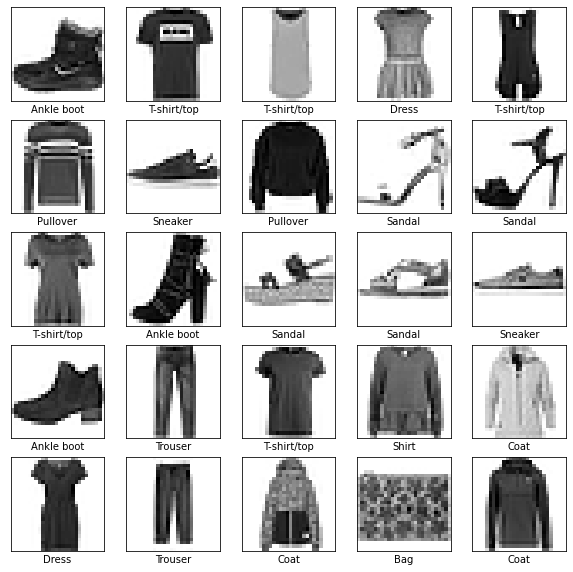

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### 모델 구성

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


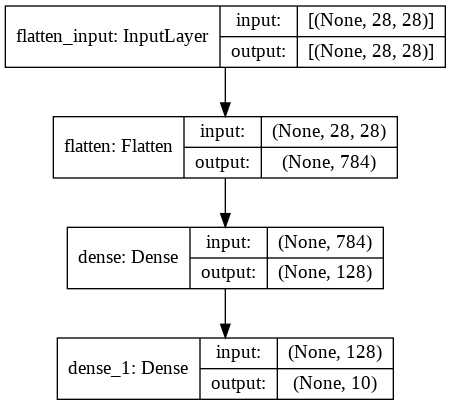

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam', # SGD, SGD + momentum
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6372 - accuracy: 0.7811
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3899 - accuracy: 0.8604
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3421 - accuracy: 0.8763
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3163 - accuracy: 0.8843
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2913 - accuracy: 0.8917


In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

313/313 - 0s - loss: 0.3790 - accuracy: 0.8665
Test loss: 0.37901976704597473
Test accuracy: 0.8665000200271606


In [ ]:
# 훈련된 모델을 사용하여 이미지에 대한 예측 만들기
predictions = model.predict(test_images)

In [ ]:
# 테스트 세트에 있는 각 이미지에 대한 예측을 진행한 후, 첫번째 예측 값
# 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냄
predictions[0]

array([2.3028070e-07, 3.7710961e-08, 1.5030743e-08, 7.9795255e-09,
       4.3214703e-09, 1.9712974e-03, 3.0058422e-07, 6.4831404e-03,
       1.1724497e-05, 9.9153322e-01], dtype=float32)

In [ ]:
# 가장 높은 신뢰도를 가진 레이블 출력
np.argmax(predictions[0])

9

In [ ]:
# 실제 테스트 데이터의 0번째 값
test_labels[0]

9

In [ ]:
# 10개의 클래스에 대한 예측을 모두 그래프로 표현
# 올바르게 예측된 레이블은 파란색으로, 잘못 예측된 레이블은 빨강색으로 표현
# 숫자는 예측 레이블의 신뢰도 퍼센트
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

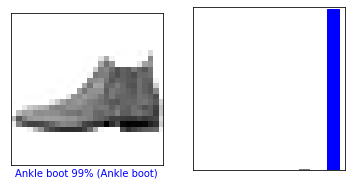

In [ ]:
# 0번째 원소의 이미지, 예측, 신뢰도 점수 배열
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

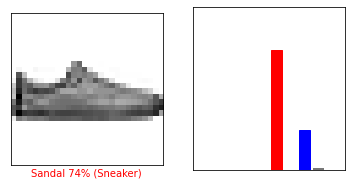

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

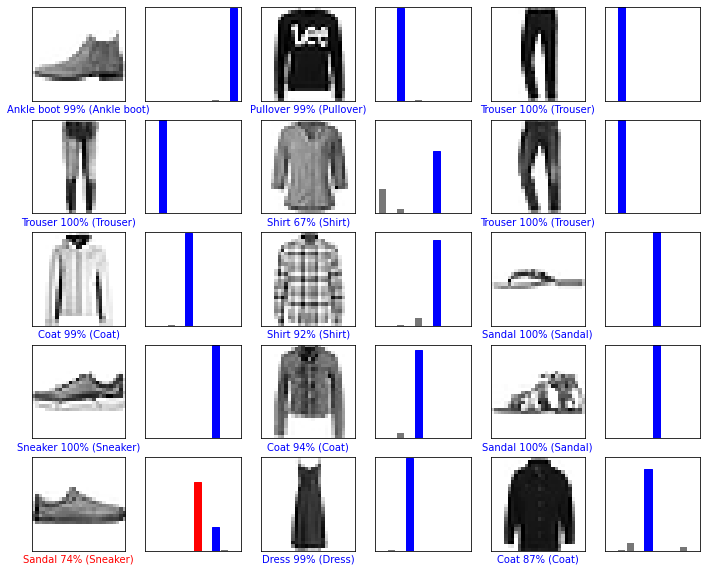

In [ ]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()